## Aim

We want to solve a PDE of the form

$$
\partial_t \mathbf{Q} + \partial_{x_i} \mathbf{F}_i = NC_i \partial_{x_i} \mathbf{Q} + \mathbf{S}
$$

where $\mathbf{F}$ is a flux, $NC$ is a non-conservative matrix, $\mathbf{S}$ is a source term and dimension $i=[1]$ for 1d, $i=[1,2]$ for 2d and $i = [1, 2,3]$ for 3d.



## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import deepcopy
import seaborn

seaborn.set_context("talk")
from IPython.display import Math
import sympy as sym

main_dir = os.getenv("ZOOMY_DIR")
import pytest
from types import SimpleNamespace

from zoomy_core.model.model import *
from pysolver.solver import *
from pysolver.solver import jax_fvm_unsteady_semidiscrete as fvm_unsteady
import zoomy_core.model.initial_conditions as IC
import zoomy_core.model.boundary_conditions as BC
from pysolver.ode import RK1
import zoomy_core.misc.io as io
from pysolver.reconstruction import GradientMesh
import zoomy_core.mesh.mesh as petscMesh
import postprocessing.postprocessing as postprocessing

## 1d Model Simple

### Model definition

In [2]:
class ShallowMomentsSedimentSimple(Model):
    """
    Shallow Moments Sediment 1d

    :gui:
    - tab: model
    - requires: [ 'mesh.dimension': 1 ]

    """

    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        aux_initial_conditions=IC.Constant(),
        dimension=1,
        fields=3,
        aux_variables=0,
        parameters={},
        _default_parameters={"g": 1.0, "ex": 0.0, "ez": 1.0},
        settings={},
        settings_default={"topography": False, "friction": []},
        basis=Basis(),
    ):
        self.basis = basis
        self.variables = register_sympy_attribute(fields, "q")
        self.n_variables = self.variables.length()
        self.level = self.n_variables - 3
        self.basis.compute_matrices(self.level)
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_variables=aux_variables,
            parameters=parameters,
            _default_parameters=_default_parameters,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            aux_initial_conditions=aux_initial_conditions,
            settings={**settings_default, **settings},
        )

    def quasilinear_matrix(self):
        nc = Matrix([[0 for i in range(self.n_variables)] for j in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1:-1]
        a = [_ha / h for _ha in ha]
        u = a[0]
        p = self.parameters
        ub = 0
        for i in range(self.level + 1):
            ub += a[i]

        def my_abs(x):
            return sym.Abs(x)

        tau = p.epsilon * p.rho * my_abs(ub) * ub
        theta = (my_abs(tau) * p.d_s**2) / (p.g * (p.rho_s - p.rho) * d_s**3)

        def pos(x):
            return sym.Piecewise((x, x > 0), (0, True))

        def sign(x):
            return sym.sign(x)

        delta_q = (
            (24 * p.Q)
            / (1 - p.phi)
            * sign(tau)
            * p.epsilon
            / (p.g * (1 / p.r - 1) * p.d_s)
            * (pos(theta - p.theta_c)) ** (1 / 2)
            * ub
            / h
        )

        nc[0, 1] = 1
        nc[1, 0] = p.g * h - u**2

        nc[1, 1] = 2 * u / self.basis.M[0, 0]
        if self.level > 0:
            nc[1, 2] = 2 * u / self.basis.M[1, 1]
        nc[1, -1] = p.g * h

        if self.level > 0:
            nc[2, 0] = -2 * a[0] * a[1]
            nc[2, 1] = 2 * a[1]
        if self.level > 1:
            nc[3, 0] = -2 / self.basis.M[1, 1] * a[1] ** 2

        for k in range(1, self.level + 1):
            nc[1 + k, 1 + k] = a[0]
            N = k + 1
            nc[1 + k, 1 + k + 1] = (N + 1) / (2 * N + 1) * a[1]
            nc[1 + k + 1, 1 + k] = (N - 1) / (2 * N - 1) * a[1]

        nc[-1, 0] = -ub * delta_q
        nc[-1, 1] = delta_q
        for k in range(1, self.level + 1):
            nc[-1, 1 + k] = delta_q
        return [-nc]

    def eigenvalues(self):
        evs = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        hu = self.variables[1]
        u = hu / h
        p = self.parameters
        evs[0] = sym.sqrt(p.g * h) + u
        evs[1] = sym.sqrt(p.g * h) - u
        return evs

    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        if self.settings.topography:
            out += self.topography()
        if self.settings.friction:
            for friction_model in self.settings.friction:
                out += getattr(self, friction_model)()
        return out

    def newtonian(self):
        """
        :gui:
            - requires_parameter: ('nu', 0.0)
        """
        assert "nu" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        out[:-1, 0] = self.smm.newtonian()
        return out

    def manning(self):
        """
        :gui:
            - requires_parameter: ('epsilon', 1000.0)
        """
        assert "epsilon" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        a = [_ha / h for _ha in ha]
        p = self.parameters
        ub = 0
        for i in range(self.level + 1):
            ub += a[i]

        def my_abs(x):
            return sym.Abs(x)
            # return sym.piecewise_fold(sym.Piecewise((-x, x<0), (x, True)))
            # return (sym.Piecewise((-x, x<0), (x, True)))

        for k in range(1 + self.level):
            out[1 + k] += -(p.epsilon * 0.01 * self.basis.M[k, k]) * ub * my_abs(ub)
        return out

### Mesh and model construction

In [3]:
# | code-fold: true
# | code-summary: "Initialize model and mesh"
mesh = petscMesh.Mesh.create_1d((-6, 6), 600)

bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag="left"),
        BC.Extrapolation(tag="right"),
    ]
)

level = 2


def custom_ic(x):
    Q = np.zeros(1 + level + 1 + 1, dtype=float)
    Q[0] = np.where(x[0] < 0, 1.0, 0.05)
    return Q


ic = IC.UserFunction(custom_ic)


d_s = 3.9 * 10 ** (-3)
rho = 1000.0
rho_s = 1580.0
r = rho / rho_s
g = 9.81
phi = 0.47
# n = 1.
# d_50 = 1.
# epsilon = (g * n**2)/((7/6)**2 * d_50**(1/3))
epsilon = 0.0324
Q = d_s * np.sqrt(g * (1 / r - 1) * d_s)
# Q = 0.
theta_c = 0.047
# theta_c = 0


fields = ["h"] + [f"hu_{l}" for l in range(level + 1)] + ["b"]
model = ShallowMomentsSedimentSimple(
    boundary_conditions=bcs,
    initial_conditions=ic,
    fields=fields,
    settings={"friction": ["manning"]},
    # settings={"friction": []},
    parameters={
        "g": g,
        "ez": 1.0,
        "d_s": d_s,
        "rho": rho,
        "rho_s": rho_s,
        "r": r,
        "phi": phi,
        "epsilon": epsilon,
        "Q": Q,
        "theta_c": theta_c,
    },
)

IndexError: list index out of range

### Simulation

In [ ]:
# | code-fold: false
# | code-summary: "Simulation"
# | output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.Zero(),
    nc_flux=nonconservative_flux.segmentpath(3),
    # compute_dt=timestepping.adaptive(CFL=.5),
    compute_dt=timestepping.constant(dt=0.001),
    time_end=1.0,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir=f"outputs/demo/swe-lvl{level}",
)


solver_price_c(mesh, model, settings, ode_solver_source=RKimplicit)

1 0.0031927542840705044 0.0031927542840705044-------------------- 
2 0.006305596540246019 0.0031128422561755146
3 0.00923925403564856 0.0029336574954025403
4 0.012080955345202884 0.0028417013095543247
5 0.01485227759770509 0.0027713222525022055
6 0.01755856424795996 0.002706286650254869
7 0.02022122743260649 0.00266266318464653
8 0.022852755868704517 0.002631528436098027


<lambdifygenerated-58>:5: RuntimeWarning: invalid value encountered in sqrt
  return (array([[1.0e-20*h, 1.0e-20*h - 1, 1.0e-20*h], [-g*h + hu_0**2/h**2, -2.0*hu_0/h, -g*h], [24*Q*epsilon*hu_0**2*select([greater(16858005.0236855*d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - theta_c, 0),True], [4105.85009756634*sqrt(d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - 5.9319e-8*theta_c),0], default=nan)*sign(epsilon*hu_0*rho*abs(hu_0/h)/h)/(d_s*g*h**3*(-1 + r**(-1.0))*(1 - phi)), -24*Q*epsilon*hu_0*select([greater(16858005.0236855*d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - theta_c, 0),True], [4105.85009756634*sqrt(d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - 5.9319e-8*theta_c),0], default=nan)*sign(epsilon*hu_0*rho*abs(hu_0/h)/h)/(d_s*g*h**2*(-1 + r**(-1.0))*(1 - phi)), 1.0e-20*h]]))


9 0.025460987989634594 0.002608232120930076
10 0.028043541702742012 0.002582553713107419
11 0.03060282821871182 0.0025592865159698103
12 0.033144892765216594 0.0025420645465047704
13 0.03567379824421798 0.0025289054790013825
14 0.038192203064795795 0.002518404820577817
15 0.04069635261068304 0.0025041495458872436
16 0.043189701525625124 0.002493348914942086
17 0.045674671672680904 0.002484970147055779
18 0.04815299584015134 0.00247832416747044
19 0.05062392958925413 0.0024709337491027905
20 0.053087669749157684 0.0024637401599035573
21 0.05554575206496415 0.002458082315806468
22 0.057999301988261004 0.0024535499232968545
23 0.06044861742799514 0.002449315439734141
24 0.06289296764752245 0.002444350219527311
25 0.06533336198982981 0.0024403943423073607
26 0.06777055498166518 0.002437192991835372
27 0.07020493933594191 0.002434384354276725
28 0.07263581133636406 0.0024308720004221547
29 0.07506385130508507 0.0024280399687210117
30 0.07748957678647256 0.0024257254813874847
31 0.0799131210

Settings(name='Simulation', parameters={}, reconstruction=<function constant at 0x7fd5caa83a60>, reconstruction_edge=<function constant_edge at 0x7fd5caa83af0>, num_flux=<function Zero.<locals>.flux at 0x7fd5abb3f3a0>, nc_flux=<function segmentpath.<locals>.nc_flux_quasilinear at 0x7fd5abb3f4c0>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7fd5abb3f5e0>, time_end=1.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/demo/swe-lvl0', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False)

### Postprocessing

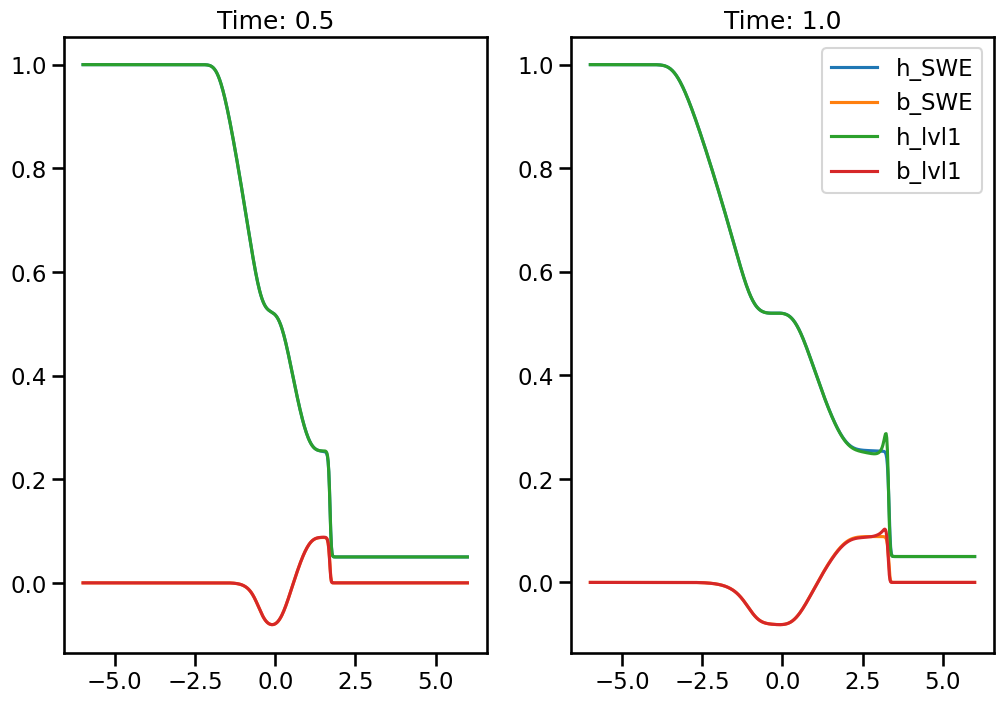

In [ ]:
# | code-fold: true
# | code-summary: "Postprocessing"


def append_to_plot(ax, X, Q, prefix=""):
    i_time = 50
    ax[0].plot(X, Q[i_time, 0, :], label=f"h_{prefix}")
    # ax[0].plot(X, Q[i_time, 2, :], label=f'a_{prefix}')
    ax[0].plot(X, Q[i_time, -1, :], label=f"b_{prefix}")
    ax[0].set_title(f"Time: {np.round(T[i_time], 1)}")

    i_time = -1
    ax[1].plot(X, Q[i_time, 0, :], label=f"h_{prefix}")
    # ax[1].plot(X, Q[i_time, 2, :], label=f'a_{prefix}')
    ax[1].plot(X, Q[i_time, -1, :], label=f"b_{prefix}")
    ax[1].set_title(f"Time: {np.round(T[i_time], 1)}")
    return ax


# filepath = os.path.join(settings.output.directory, 'Simulation.h5')
filepath = os.path.join("outputs/demo/swe-lvl0", "Simulation.h5")
X, Q, Qaux, T = io.load_timeline_of_fields_from_hdf5(filepath)
# remove the boundary points
Q = Q[:, :, :-2]
X = X[:-2]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax = append_to_plot(ax, X.copy(), Q.copy(), prefix="SWE")

filepath = os.path.join("outputs/demo/swe-lvl1", "Simulation.h5")
X, Q, Qaux, T = io.load_timeline_of_fields_from_hdf5(filepath)
# remove the boundary points
Q = Q[:, :, :-2]
X = X[:-2]

ax = append_to_plot(ax, X.copy(), Q.copy(), prefix="lvl1")
plt.legend()

## 1d Model

### Model definition

In [ ]:
class ShallowMomentsSediment(Model):
    """
    Shallow Moments Sediment 1d

    :gui:
    - tab: model
    - requires: [ 'mesh.dimension': 1 ]

    """

    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        aux_initial_conditions=IC.Constant(),
        dimension=1,
        fields=3,
        aux_variables=0,
        parameters={},
        _default_parameters={"g": 1.0, "ex": 0.0, "ez": 1.0},
        settings={},
        settings_default={"topography": False, "friction": []},
        basis=Basis(),
    ):
        self.basis = basis
        self.variables = register_sympy_attribute(fields, "q")
        self.n_variables = self.variables.length()
        self.level = self.n_variables - 3
        self.basis.compute_matrices(self.level)
        if type(fields) == type([]):
            fields_smm = fields[:-1]
        elif type(fields) == int:
            fields_smm = fields - 1
        else:
            assert False
        self.smm = ShallowMoments(
            dimension=dimension,
            fields=fields_smm,
            aux_variables=aux_variables,
            parameters=parameters,
            _default_parameters=_default_parameters,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            aux_initial_conditions=aux_initial_conditions,
        )
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_variables=aux_variables,
            parameters=parameters,
            _default_parameters=_default_parameters,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            aux_initial_conditions=aux_initial_conditions,
            settings={**settings_default, **settings},
        )

    def flux(self):
        flux = Matrix([0 for i in range(self.n_variables)])
        # smm flux
        flux[:-1, 0] = self.smm.sympy_flux[0]

        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        a = [_ha / h for _ha in ha]
        p = self.parameters
        # bedload equation
        ub = a[0]

        def my_abs(x):
            return sym.Abs(x)
            # return sym.Piecewise((x, x>=0), (-x, True))

        for i in range(self.level):
            ub += a[i + 1]
        tau = p.epsilon * p.rho * my_abs(ub) * ub
        theta = (my_abs(tau) * p.d_s**2) / (p.g * (p.rho_s - p.rho) * d_s**3)

        def pos(x):
            # return x**2
            return sym.Piecewise((x, x > 0), (0, True))

        def sign(x):
            return sym.Piecewise((-1, x < 0), (+1, x > 0), (0, True))
            # return sym.sign(x)
            # return x

        # theta = p.theta_c
        # flux[-1, 0]  = p.Q * (sign(tau)*8/(1-p.phi) * (pos(theta - p.theta_c))**(3/2) )
        # flux[-1, 0]  = p.Q * (sign(tau)*8/(1-p.phi) * (pos(theta - p.theta_c)))
        flux[-1, 0] = (
            10 ** (-6)
            * p.Q
            * (sign(tau) * 8 / (1 - p.phi) * ((theta - p.theta_c) ** 2))
        )
        return [-flux]

    def nonconservative_matrix(self):
        nc = Matrix([[0 for i in range(self.n_variables)] for j in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        a = [_ha / h for _ha in ha]
        p = self.parameters
        um = ha[0] / h
        ub = a[0]

        def my_abs(x):
            return sym.Abs(x)
            # return sym.Piecewise((-x, x<0), (x, True))

        for i in range(self.level):
            ub += a[i + 1]
        tau = p.epsilon * p.rho * my_abs(ub) * ub
        theta = (my_abs(tau) * p.d_s**2) / (p.g * (p.rho_s - p.rho) * d_s**3)

        def pos(x):
            return sym.Piecewise((x, x > 0), (0, True))

        def sign(x):
            # return sym.Piecewise((-1, x<0), (+1, x>0), (0, True))
            return sym.sign(x)

        # theta = p.theta_c
        # delta_q = (24 * p.Q)/(1-p.phi) * sign(tau) * p.epsilon / (p.g * (1/p.r - 1) * p.d_s) * (pos(theta - p.theta_c))**(1/2) * ub / h
        delta_q = (
            10 ** (-6)
            * (24 * p.Q)
            / (1 - p.phi)
            * sign(tau)
            * p.epsilon
            / (p.g * (1 / p.r - 1) * p.d_s)
            * (sym.Abs(theta)) ** (1 / 2)
            * ub
            / h
        )
        nc[-1, 0] = -ub * delta_q
        for l in range(self.level + 1):
            nc[-1, l + 1] = delta_q
        return [nc]

    def eigenvalues(self):
        A = self.normal[0] * self.sympy_quasilinear_matrix[0]
        for d in range(1, self.dimension):
            A += self.normal[d] * self.sympy_quasilinear_matrix[d]
        if self.level > 1:
            alpha_erase = self.variables[2:-1]
            for alpha_i in alpha_erase:
                A = A.subs(alpha_i, 0)
        for i in range(self.n_variables):
            A[-1, i] = 0
        return eigenvalue_dict_to_matrix(A.eigenvals())

    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        if self.settings.topography:
            out += self.topography()
        if self.settings.friction:
            for friction_model in self.settings.friction:
                out += getattr(self, friction_model)()
        return out

    def newtonian(self):
        """
        :gui:
            - requires_parameter: ('nu', 0.0)
        """
        assert "nu" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        out[:-1, 0] = self.smm.newtonian()
        return out

    def manning(self):
        """
        :gui:
            - requires_parameter: ('epsilon', 1000.0)
        """
        assert "epsilon" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        a = [_ha / h for _ha in ha]
        p = self.parameters
        ub = a[0]

        def my_abs(x):
            return sym.Abs(x)
            # return sym.piecewise_fold(sym.Piecewise((-x, x<0), (x, True)))
            # return (sym.Piecewise((-x, x<0), (x, True)))

        for i in range(self.level):
            ub += a[i + 1]
        for k in range(1 + self.level):
            for l in range(1 + self.level):
                out[1 + k] += -(p.epsilon * self.basis.M[k, k]) * ub * my_abs(ub)
        return out

### Mesh and model construction

In [ ]:
# | code-fold: true
# | code-summary: "Initialize model and mesh"
mesh = petscMesh.Mesh.create_1d((-6, 6), 200)

bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag="left"),
        BC.Extrapolation(tag="right"),
    ]
)

level = 0


def custom_ic(x):
    Q = np.zeros(1 + level + 1 + 1, dtype=float)
    Q[0] = np.where(x[0] < 0, 1.0, 0.95)
    return Q


ic = IC.UserFunction(custom_ic)


d_s = 3.9 * 10 ** (-3)
rho = 1000.0
rho_s = 1580.0
r = rho / rho_s
g = 9.81
phi = 0.47
n = 1.0
d_50 = 1.0
# epsilon = (g * n**2)/((7/6)**2 * d_50**(1/3))
epsilon = 0.0324
Q = d_s * np.sqrt(g * (1 / r - 1) * d_s)
# Q = 0.
# theta_c = 0.047
theta_c = 0


fields = ["h"] + [f"hu_{l}" for l in range(level + 1)] + ["b"]
model = ShallowMomentsSediment(
    boundary_conditions=bcs,
    initial_conditions=ic,
    fields=fields,
    settings={"friction": ["manning"]},
    parameters={
        "nu": 0.01,
        "g": g,
        "ez": 1.0,
        "d_s": d_s,
        "rho": rho,
        "rho_s": rho_s,
        "r": r,
        "phi": phi,
        "n": n,
        "d_50": d_50,
        "epsilon": epsilon,
        "Q": Q,
        "theta_c": theta_c,
    },
)

IndexError: list index out of range

### Display model

In [ ]:
# | code-fold: true
# | code-summary: "Display model"
display(Math(r"\large{" + "Flux \, in \, x" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_flux[0])) + "}"))
# display(Math(r'\large{' + 'Nonconservative \, matrix \, in \, x' + '}'))
# display(Math(r'\large{' + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[0])) + '}'))
display(Math(r"\large{" + "Eigenvalues" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_eigenvalues)) + "}"))
display(Math(r"\large{" + "Source" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_source)) + "}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulation

In [ ]:
# | code-fold: false
# | code-summary: "Simulation"
# | output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.Zero(),
    nc_flux=nonconservative_flux.segmentpath(3),
    compute_dt=timestepping.adaptive(CFL=0.1),
    time_end=1.0,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/demo/swe",
)


solver_price_c(mesh, model, settings)

1 0.0019156525704423027 0.0019156525704423027-------------------- 


<lambdifygenerated-175>:5: RuntimeWarning: invalid value encountered in divide
  return (array([[1.0e-20*h, 1.0e-20*h - 1, 1.0e-20*h], [-ez*g*h + 1.0*hu_0**2/h**2, -2.0*hu_0/h, 1.0e-20*h], [-4547077334.05769*Q*d_s**2*(d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - 5.9319e-8*theta_c)*(-epsilon*hu_0**2*rho*sign(hu_0/h)/h**3 - epsilon*hu_0**2*rho/(h**3*sign(hu_0/h)))*select([less(epsilon*hu_0*rho*abs(hu_0/h)/h, 0),greater(epsilon*hu_0*rho*abs(hu_0/h)/h, 0),True], [-1,1,0], default=nan)*sign(epsilon*hu_0**2*rho/(h**2*sign(hu_0/h)))/(g*(1 - phi)*(-rho + rho_s)) + 0.0985404023415921*Q*epsilon*hu_0**2*abs(d_s)**1.0*sqrt(abs(abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(rho - rho_s))))*sign(epsilon*hu_0*rho*abs(hu_0/h)/h)/(d_s*g*h**3*(-1 + r**(-1.0))*(1 - phi)), -4547077334.05769*Q*d_s**2*(d_s**2*abs(epsilon*hu_0*rho*abs(hu_0/h)/h)/(g*(-rho + rho_s)) - 5.9319e-8*theta_c)*(epsilon*hu_0*rho*sign(hu_0/h)/h**2 + epsilon*hu_0*rho/(h**2*sign(hu_0/h)))*select([less(epsilon*hu_0*rho*abs(hu_

AssertionError: 

### Postprocessing

In [ ]:
# | code-fold: true
# | code-summary: "Postprocessing"
filepath = os.path.join(settings.output.directory, "Simulation.h5")
X, Q, Qaux, T = io.load_timeline_of_fields_from_hdf5(filepath)
# remove the boundary points
Q = Q[:, :, :-2]
X = X[:-2]

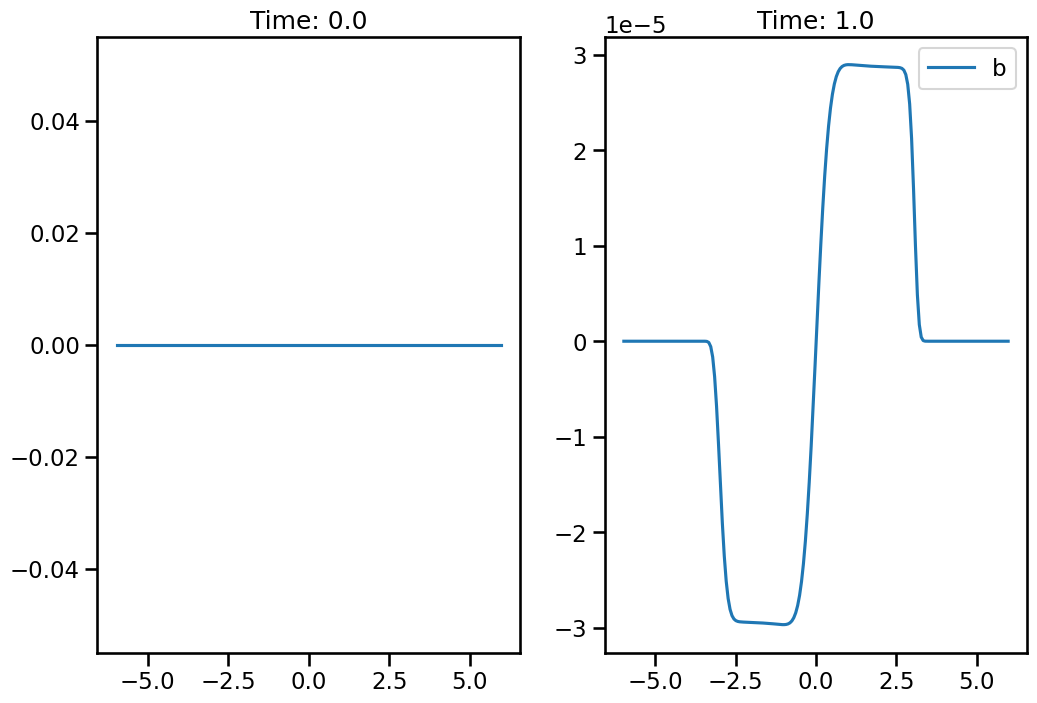

In [ ]:
# | code-fold: false
# | code-summary: "Plot with Matplotlib"
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
i_time = 0
# ax[0].plot(X, Q[i_time, 0, :], label='h')
# ax[0].plot(X, Q[i_time, 1, :]/Q[i_time, 0, :], label='u')
ax[0].plot(X, Q[i_time, 2, :], label="b")
ax[0].set_title(f"Time: {T[i_time]}")

i_time = -1
# ax[1].plot(X, Q[i_time, 0, :], label='h')
# ax[1].plot(X, Q[i_time, 1, :]/Q[i_time, 0, :], label='u')
ax[1].plot(X, Q[i_time, 2, :], label="b")
ax[1].set_title(f"Time: {np.round(T[i_time], 1)}")
plt.legend()

## 2d Model

### Model

In [ ]:
class ShallowMomentsSediment2d(Model):
    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        dimension=2,
        fields=3,
        aux_variables=0,
        parameters={},
        _default_parameters={"g": 1.0, "ex": 0.0, "ey": 0.0, "ez": 1.0},
        settings={},
        settings_default={"topography": False, "friction": []},
        basis=Basis(),
    ):
        self.basis = basis
        self.variables = register_sympy_attribute(fields, "q")
        self.n_variables = self.variables.length()
        self.level = int((self.n_variables - 1) / 2) - 1
        self.basis.compute_matrices(self.level)
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_variables=aux_variables,
            parameters=parameters,
            _default_parameters=_default_parameters,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            settings={**settings_default, **settings},
        )

    def flux(self):
        offset = self.level + 1
        flux_x = Matrix([0 for i in range(self.n_variables)])
        flux_y = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        hb = self.variables[1 + self.level + 1 : 1 + 2 * (self.level + 1)]
        p = self.parameters
        flux_x[0] = ha[0]
        flux_x[1] = p.g * p.ez * h * h / 2
        for k in range(self.level + 1):
            for i in range(self.level + 1):
                for j in range(self.level + 1):
                    # TODO avoid devision by zero
                    flux_x[k + 1] += (
                        ha[i] * ha[j] / h * self.basis.A[k, i, j] / self.basis.M[k, k]
                    )
        for k in range(self.level + 1):
            for i in range(self.level + 1):
                for j in range(self.level + 1):
                    # TODO avoid devision by zero
                    flux_x[k + 1 + offset] += (
                        hb[i] * ha[j] / h * self.basis.A[k, i, j] / self.basis.M[k, k]
                    )

        flux_y[0] = hb[0]
        flux_y[1 + offset] = p.g * p.ez * h * h / 2
        for k in range(self.level + 1):
            for i in range(self.level + 1):
                for j in range(self.level + 1):
                    # TODO avoid devision by zero
                    flux_y[k + 1] += (
                        hb[i] * ha[j] / h * self.basis.A[k, i, j] / self.basis.M[k, k]
                    )
        for k in range(self.level + 1):
            for i in range(self.level + 1):
                for j in range(self.level + 1):
                    # TODO avoid devision by zero
                    flux_y[k + 1 + offset] += (
                        hb[i] * hb[j] / h * self.basis.A[k, i, j] / self.basis.M[k, k]
                    )
        return [flux_x, flux_y]

    def nonconservative_matrix(self):
        offset = self.level + 1
        nc_x = Matrix([[0 for i in range(self.n_variables)] for j in range(self.n_variables)])
        nc_y = Matrix([[0 for i in range(self.n_variables)] for j in range(self.n_variables)])
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        hb = self.variables[1 + offset : 1 + offset + self.level + 1]
        p = self.parameters
        um = ha[0] / h
        vm = hb[0] / h
        for k in range(1, self.level + 1):
            nc_x[k + 1, k + 1] += um
            nc_y[k + 1, k + 1 + offset] += um
        for k in range(self.level + 1):
            for i in range(1, self.level + 1):
                for j in range(1, self.level + 1):
                    nc_x[k + 1, i + 1] -= (
                        ha[j] / h * self.basis.B[k, i, j] / self.basis.M[k, k]
                    )
                    nc_y[k + 1, i + 1 + offset] -= (
                        ha[j] / h * self.basis.B[k, i, j] / self.basis.M[k, k]
                    )

        for k in range(1, self.level + 1):
            nc_x[k + 1 + offset, k + 1] += vm
            nc_y[k + 1 + offset, k + 1 + offset] += vm
        for k in range(self.level + 1):
            for i in range(1, self.level + 1):
                for j in range(1, self.level + 1):
                    nc_x[k + 1 + offset, i + 1] -= (
                        hb[j] / h * self.basis.B[k, i, j] / self.basis.M[k, k]
                    )
                    nc_y[k + 1 + offset, i + 1 + offset] -= (
                        hb[j] / h * self.basis.B[k, i, j] / self.basis.M[k, k]
                    )
        return [nc_x, nc_y]

    def eigenvalues(self):
        # we delete heigher order moments (level >= 2) for analytical eigenvalues
        offset = self.level + 1
        A = self.normal[0] * self.sympy_quasilinear_matrix[0]
        for d in range(1, self.dimension):
            A += self.normal[d] * self.sympy_quasilinear_matrix[d]
        alpha_erase = self.variables[2 : 2 + self.level]
        beta_erase = self.variables[2 + offset : 2 + offset + self.level]
        for alpha_i in alpha_erase:
            A = A.subs(alpha_i, 0)
        for beta_i in beta_erase:
            A = A.subs(beta_i, 0)
        return eigenvalue_dict_to_matrix(A.eigenvals())

    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        if self.settings.topography:
            out += self.topography()
        if self.settings.friction:
            for friction_model in self.settings.friction:
                out += getattr(self, friction_model)()
        return out

    def topography(self):
        assert "dhdx" in vars(self.aux_variables)
        assert "dhdy" in vars(self.aux_variables)
        offset = self.level + 1
        out = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        p = self.parameters
        dhdx = self.aux_variables.dhdx
        dhdy = self.aux_variables.dhdy
        out[1] = h * p.g * (p.ex - p.ez * dhdx)
        out[1 + offset] = h * p.g * (p.ey - p.ez * dhdy)
        return out

    def newtonian(self):
        assert "nu" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        offset = self.level + 1
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        hb = self.variables[1 + offset : 1 + self.level + 1 + offset]
        p = self.parameters
        for k in range(1 + self.level):
            for i in range(1 + self.level):
                out[1 + k] += (
                    -p.nu / h * ha[i] / h * self.basis.D[i, k] / self.basis.M[k, k]
                )
                out[1 + k + offset] += (
                    -p.nu / h * hb[i] / h * self.basis.D[i, k] / self.basis.M[k, k]
                )
        return out

    def slip(self):
        assert "lamda" in vars(self.parameters)
        assert "rho" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        offset = self.level + 1
        h = self.variables[0]
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        hb = self.variables[1 + offset : 1 + self.level + 1 + offset]
        p = self.parameters
        for k in range(1 + self.level):
            for i in range(1 + self.level):
                out[1 + k] += -1.0 / p.lamda / p.rho * ha[i] / h / self.basis.M[k, k]
                out[1 + k + offset] += (
                    -1.0 / p.lamda / p.rho * hb[i] / h / self.basis.M[k, k]
                )
        return out

    def chezy(self):
        assert "C" in vars(self.parameters)
        out = Matrix([0 for i in range(self.n_variables)])
        offset = self.level + 1
        h = self.variables[0]
        ha = self.variables[1 : 1 + self.level + 1]
        hb = self.variables[1 + offset : 1 + self.level + 1 + offset]
        p = self.parameters
        tmp = 0
        for i in range(1 + self.level):
            for j in range(1 + self.level):
                tmp += ha[i] * ha[j] / h / h + hb[i] * hb[j] / h / h
        sqrt = sympy.sqrt(tmp)
        for k in range(1 + self.level):
            for l in range(1 + self.level):
                out[1 + k] += -1.0 / (p.C**2 * self.basis.M[k, k]) * ha[l] * sqrt / h
                out[1 + k + offset] += (
                    -1.0 / (p.C**2 * self.basis.M[k, k]) * hb[l] * sqrt / h
                )
        return out

### Mesh

In [ ]:
# | code-fold: false
# | code-summary: "Load Gmsh mesh"

# mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_coarse.msh"))
mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_fine.msh"))
# mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/quad_2d/mesh_finest.msh"))
# mesh = petscMesh.Mesh.from_gmsh(os.path.join(main_dir, "meshes/triangle_2d/mesh_finest.msh"))
print(f"physical tags in gmsh file: {mesh.boundary_conditions_sorted_names}")


physical tags in gmsh file: ['right' 'left' 'bottom' 'top']


### Model

In [ ]:
# | code-summary: "Model"
# | code-fold: false

bcs = BC.BoundaryConditions(
    [
        BC.Periodic(tag="left", periodic_to_physical_tag="right"),
        BC.Periodic(tag="right", periodic_to_physical_tag="left"),
        BC.Periodic(tag="top", periodic_to_physical_tag="bottom"),
        BC.Periodic(tag="bottom", periodic_to_physical_tag="top"),
    ]
)


def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] ** 2 + x[1] ** 2 < 0.1, 2.0, 1.0)
    return Q


ic = IC.UserFunction(custom_ic)


model = ShallowMomentsSediment2d(
    boundary_conditions=bcs,
    initial_conditions=ic,
    fields=["h", "hu", "hv"],
    settings={"friction": ["chezy"]},
    parameters={"C": 1.0, "g": 9.81, "ez": 1.0},
)

### Automatic tex generation

In [ ]:
# | code-summary: "Display Model"
# | code-fold: true
display(Math(r"\large{" + "Flux \, in \, x" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_flux[0])) + "}"))
display(Math(r"\large{" + "Flux \, in \, y" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_flux[1])) + "}"))
display(Math(r"\large{" + "Nonconservative \, matrix \, in \, x" + "}"))
display(
    Math(
        r"\large{"
        + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[0]))
        + "}"
    )
)
display(Math(r"\large{" + "Nonconservative \, matrix \, in \, y" + "}"))
display(
    Math(
        r"\large{"
        + sympy.latex(sympy.simplify(model.sympy_nonconservative_matrix[1]))
        + "}"
    )
)
display(Math(r"\large{" + "Quasilinear \, matrix \, in \, x" + "}"))
display(
    Math(
        r"\large{"
        + sympy.latex(sympy.simplify(model.sympy_quasilinear_matrix[0]))
        + "}"
    )
)
display(Math(r"\large{" + "Quasilinear \, matrix \, in \, y" + "}"))
display(
    Math(
        r"\large{"
        + sympy.latex(sympy.simplify(model.sympy_quasilinear_matrix[1]))
        + "}"
    )
)
display(Math(r"\large{" + "Eigenvalues" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_eigenvalues)) + "}"))
display(Math(r"\large{" + "Source" + "}"))
display(Math(r"\large{" + sympy.latex(sympy.simplify(model.sympy_source)) + "}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulation

In [ ]:
# | code-fold: false
# | code-summary: "Simulation"
# | output: false

settings = Settings(
    reconstruction=recon.constant,
    num_flux=flux.Zero(),
    nc_flux=nonconservative_flux.segmentpath(3),
    compute_dt=timestepping.adaptive(CFL=0.45),
    time_end=1.0,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/demo/swe2d",
)


solver_price_c(mesh, model, settings)

1 0.006349551201342023 0.006349551201342023---------------------- 
2 0.011790914442340813 0.005441363240998789
3 0.016823182312503605 0.0050322678701627925
4 0.02204432181144432 0.005221139498940715
5 0.027082242954192745 0.005037921142748423
6 0.032217642982236595 0.00513540002804385
7 0.037438780702869025 0.005221137720632429
8 0.04246134111605379 0.0050225604131847665
9 0.04736455702511451 0.004903215909060715
10 0.05226452364948868 0.004899966624374166
11 0.057161753234978525 0.004897229585489848
12 0.06221660451580397 0.005054851280825445
13 0.06707195190359386 0.004855347387789886
14 0.07171950684195798 0.00464755493836412
15 0.07628792735349997 0.004568420511541998
16 0.08081671050405534 0.004528783150555375
17 0.08547123792926094 0.004654527425205592
18 0.09026841804727873 0.004797180118017787
19 0.09482474436773769 0.004556326320458957
20 0.09921220332219813 0.004387458954460443
21 0.10348981014899672 0.004277606826798589
22 0.10783873688768855 0.004348926738691835
23 0.112302

Settings(name='Simulation', parameters={}, reconstruction=<function constant at 0x7fd7d5a8f8b0>, reconstruction_edge=<function constant_edge at 0x7fd7d5a8f940>, num_flux=<function Zero.<locals>.flux at 0x7fd7b4705c10>, nc_flux=<function segmentpath.<locals>.nc_flux_quasilinear at 0x7fd7b4705550>, compute_dt=<function adaptive.<locals>.compute_dt at 0x7fd7b47059d0>, time_end=1.0, truncate_last_time_step=True, output_snapshots=100, output_write_all=False, output_dir='outputs/demo/swe2d', output_clean_dir=True, solver_code_base='python', callbacks=[], debug=False, profiling=False)

### Postprocessing

In [ ]:
# | code-fold: true
# | code-summary: "Postprocessing"
io.generate_vtk(
    os.path.join(os.path.join(main_dir, settings.output.directory), f"{settings.name}.h5")
)
out_0 = pv.read(os.path.join(os.path.join(main_dir, settings.output.directory), "out.0.vtk"))
out_10 = pv.read(
    os.path.join(os.path.join(main_dir, settings.output.directory), "out.10.vtk")
)
out_98 = pv.read(
    os.path.join(os.path.join(main_dir, settings.output.directory), "out.98.vtk")
)
field_names = out_0.cell_data.keys()
print(f"Field names: {field_names}")

Field names: ['0', '1', '2']


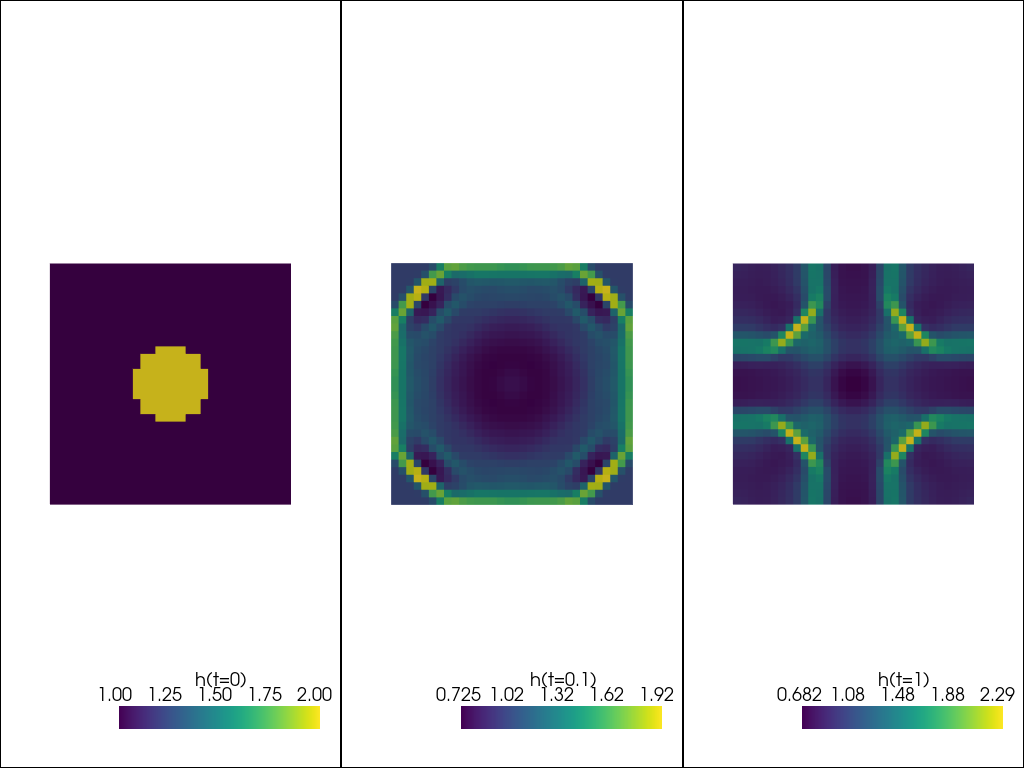

In [ ]:
# | code-fold: true
# | code-summary: "Plot VTK"
p = pv.Plotter(shape=(1, 3), notebook=True)

p.subplot(0, 0)
p.add_mesh(out_0, scalars="0", show_edges=False, scalar_bar_args={"title": "h(t=0)"})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 1)
p.add_mesh(out_10, scalars="0", show_edges=False, scalar_bar_args={"title": "h(t=0.1)"})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.subplot(0, 2)
p.add_mesh(out_98, scalars="0", show_edges=False, scalar_bar_args={"title": "h(t=1)"})
p.enable_parallel_projection()
p.enable_image_style()
p.view_xy()

p.show(jupyter_backend="static")